# Vehicle Detection and Tracking

In [1]:
import glob, os, re
import numpy as np
import cv2
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

from mpl_toolkits.mplot3d import Axes3D
from functools import partial

import dill as pickle

from tqdm import tqdm
import asyncio

from utils import *
from features import *
from boxes import *
from images import *
from detection import *
from search import *

# Import everything needed to edit/save/watch video clips
from moviepy.editor import ImageSequenceClip, VideoFileClip
from IPython.display import HTML

%matplotlib inline   

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
timages, tfiles = load_test_images()
#arr2img(cv2.cvtColor(timages[0], cv2.COLOR_BGR2RGB))
#arr2img(images[0][1])
#plt.imshow(images[0][1])

In [4]:
#vimages, vframes = load_test_video()
pimages, pframes = load_test_video(file_name='project_video.mp4')
vimages=pimages
vframes=pframes
#arr2img(cv2.cvtColor(vimages[5], cv2.COLOR_BGR2RGB))

100%|████████████████████████████████████▉| 1260/1261 [00:09<00:00, 133.09it/s]


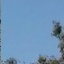

In [5]:
images, files = load_images()
arr2img(cv2.cvtColor(images[0],cv2.COLOR_BGR2RGB))

In [6]:
car_images, not_car_images = load_car_not_car_images()
len(car_images),len(not_car_images)

var/non-vehicles/Extras (5068, 64, 64, 3) 5068
var/non-vehicles/GTI (3900, 64, 64, 3) 3900
var/vehicles/GTI_Far (834, 64, 64, 3) 834
var/vehicles/GTI_Left (909, 64, 64, 3) 909
var/vehicles/GTI_MiddleClose (419, 64, 64, 3) 419
var/vehicles/GTI_Right (664, 64, 64, 3) 664
var/vehicles/KITTI_extracted (5966, 64, 64, 3) 5966


(8792, 8968)

Hog Classify
===

In [7]:
# sample_size = 10000
# cars = car_images[0:sample_size]
# notcars = not_car_images[0:sample_size]

cars = car_images
notcars = not_car_images

colorspace = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
#orient = 32
#pix_per_cell = 16
#cell_per_block = 2
#hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 32  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)
hist_bins=32
hist_range=(0, 256)

t=time.time()
# also appended a color histogram into the features
car_features = extract_hog_features(cars, colorspace, orient, 
                        pix_per_cell, cell_per_block,hog_channel,
                        spatial_size,hist_bins,hist_range)
notcar_features = extract_hog_features(notcars, colorspace, orient, 
                        pix_per_cell, cell_per_block,hog_channel,
                        spatial_size,hist_bins,hist_range)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = StandardScaler(with_mean=True, with_std=True).fit(X)
X_scaler = RobustScaler().fit(X)
# X_scaler = MinMaxScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',hog_channel,'hog channel',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

100%|█████████████████████████████████████| 8968/8968 [00:33<00:00, 266.46it/s]


59.56 Seconds to extract HOG features...
Using: ALL hog channel 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 3456


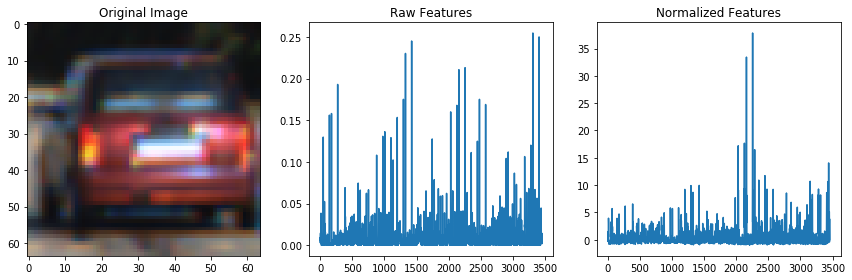

In [8]:
car_ind = np.random.randint(0, len(car_images))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(car_images[car_ind], cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [9]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

8.87 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9893
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
0.017 Seconds to predict 10 labels with SVC


In [10]:
wb = WindowBoxes(height=car_images[0].shape[0], width=car_images[0].shape[1])
total=0
for size, windows in wb.window_boxes_dict.items():
    count=len(windows)
    total = total + count
    print("{} count {}".format(size, count))

print("total", total)

small count 240
smallish count 324
large count 65
medium count 308
total 937


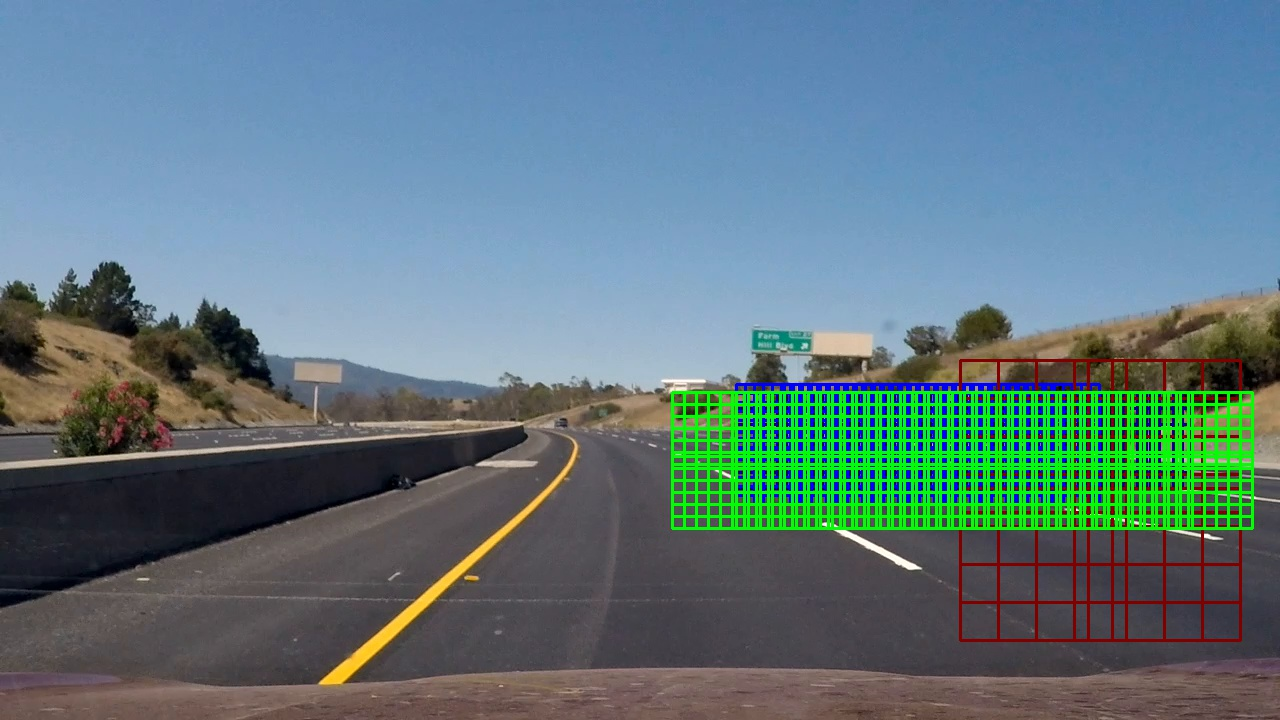

In [11]:
from boxes import WindowBoxes
images, _ = load_test_images()

@interact
def window_test(images=fixed(pimages), i:(0,len(pimages)-1)=0, 
                all_shapes=True,
                shape:wb.shape_keys="small"):    
    image=cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    height = image.shape[0]
    width = image.shape[1]
    wb = WindowBoxes(height, width)
    box_color=wb.box_colour_dict

    window_dict = wb.build_window_boxes(height, width, all_shapes, shape) 
    window_img=np.copy(image)
    for size, windows in window_dict.items():
        window_img = draw_boxes(window_img, windows, color=box_color[size], thick=2)   
    
    return arr2img(window_img)

In [12]:
# initialise an object to contain common parameters
#color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
#orient = 9  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
#cell_per_block = 2 # HOG cells per block
#hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0,256)
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

    
search_params = SearchParams(color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size,
                  hist_bins, hist_range, spatial_feat, hist_feat, hog_feat, svc, X_scaler)
print(search_params)

SearchParams(color_space='YCrCb', orient=32, pix_per_cell=16, cell_per_block=2, hog_channel='ALL', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), spatial_feat=False, hist_feat=False, hog_feat=True, clf=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), X_scaler=RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True))


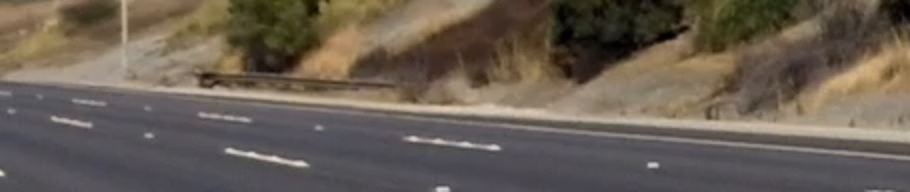

In [13]:
@interact
def camera_window_box_test(images=fixed(pimages), i:(0,len(pimages)-1)=0, shape:wb.shape_keys="small"):
    camera_image=CameraImage(images[i])
    window_boxes=WindowBoxes(camera_image.height, camera_image.width)               

    img=CameraImage.slice_bounding_box_shape_resize_64x64(camera_image.image, window_boxes, shape)
    #print(window_boxes.bounding_box(shape), window_boxes.resize_64x64_ratio(shape), img.shape)
    return arr2img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

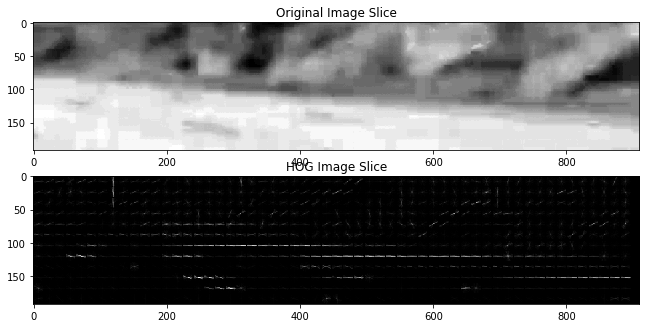

In [14]:
@interact
def hog_slice_test(images=fixed(vimages), i:(0,len(vimages)-1)=0,
                   shape:wb.shape_keys="small"):
    camera_image = CameraImage(images[i])
    window_boxes = WindowBoxes(camera_image.height, camera_image.width)
    image_slice = ImageSlice(camera_image, window_boxes, search_params, shape)
    image_windows = [wbs for wbs in image_slice.window_generator()]
    image = image_slice.image

    hog_image = image_slice.hog_image(1)
#     print(window_boxes.bounding_box(shape), window_boxes.resize_64x64_ratio(shape), image.shape)
  
    hog_features_list = image_slice.hog_features_list
#     print(len(hog_features_list))
#     print("hog_features_list[0].values.shape=",hog_features_list[0].values.shape)
#     print(image_slice.image.shape,hog_image.shape)
    #print(window_boxes.windows(shape))
#     print(image_windows)

#     for w in image_windows:
#         print("windows: %r slice_window %r hog: %r" % (w.bbox, w.bbox_slice,
#                                                        image_slice.window_hog_features(w.bbox_slice)))
    fig = plt.figure(figsize=(20,8))
    plt.subplot(311)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)[:,:,2], cmap='gray')
    plt.title('Original Image Slice')
    plt.subplot(312)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Image Slice')
#     plt.subplot(313)
#     plt.imshow(hog_image, cmap='gray')
#     plt.title('RHS Slice')
#     plt.imshow(cv2.cvtColor(image_slice.slice_window(image_windows[-1:][0].bbox_slice), cv2.COLOR_YCrCb2RGB))         

label car count 0 (1, 720, 1280) (720, 1280)
box variance []
labelled boxes []
planes []


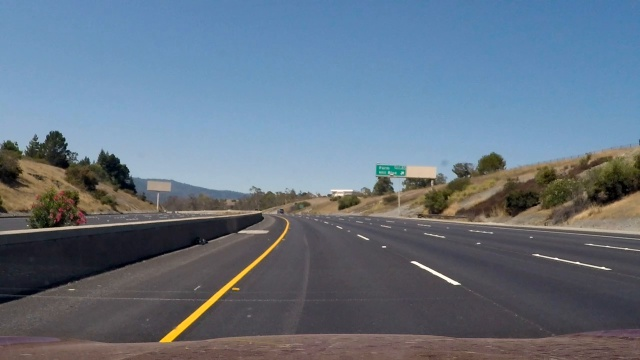

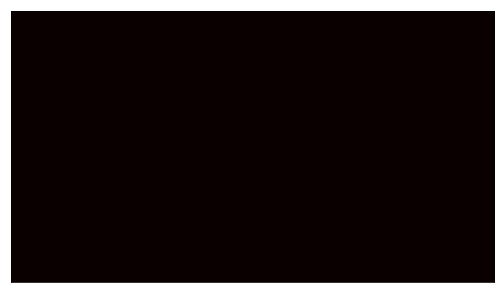

In [15]:
from matplotlib import cm
from scipy import ndimage

loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)

vehicle_detection = VehicleDetection(search_params,timages[0].shape[0], timages[0].shape[1], loop)

@interact
def hot_windows_test(images=fixed(pimages), i:(0,len(pimages)-1)=0):

#     vehicle_detection = VehicleDetection(search_params,images[i].shape[0], images[i].shape[1], loop)
    vehicle_detection.image = images[i]
    
    heatmap = vehicle_detection.heatmap
    heatmap_history = vehicle_detection.heatmap_history
    labels=vehicle_detection.labels
#     print("history count", vehicle_detection.heatmap_history_count)
    print("label car count", labels[1], labels[0].shape, labels[0][0].shape)
    print("box variance", np.around(vehicle_detection.box_variance,decimals=3))
    print("labelled boxes", vehicle_detection.labelled_boxes)
    print("planes", vehicle_detection.label_box_planes)
    
    for car_number in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            #print(car_number)
            nonzeroz = np.array(nonzero[0])
            nonzeroy = np.array(nonzero[1])
            nonzerox = np.array(nonzero[2])
            #print(nonzeroy, nonzerox, nonzeroz)
    

    nplots=vehicle_detection.heatmap_history_count
    fig = plt.figure(figsize=(15,vehicle_detection.heatmap_history_count*5))
    
    for i in range(0,vehicle_detection.heatmap_history_count):
        plt.subplot(1, nplots, i+1)
        
        heatmap=heatmap_history[i]
        plt.imshow(heatmap,cmap=plt.get_cmap('hot'))
        plt.xticks([]), plt.yticks([])
    #fig.tight_layout()     
    

    return arr2img(cv2.cvtColor(cv2.resize(vehicle_detection.result,None,fx=.5,fy=.5),cv2.COLOR_BGR2RGB))


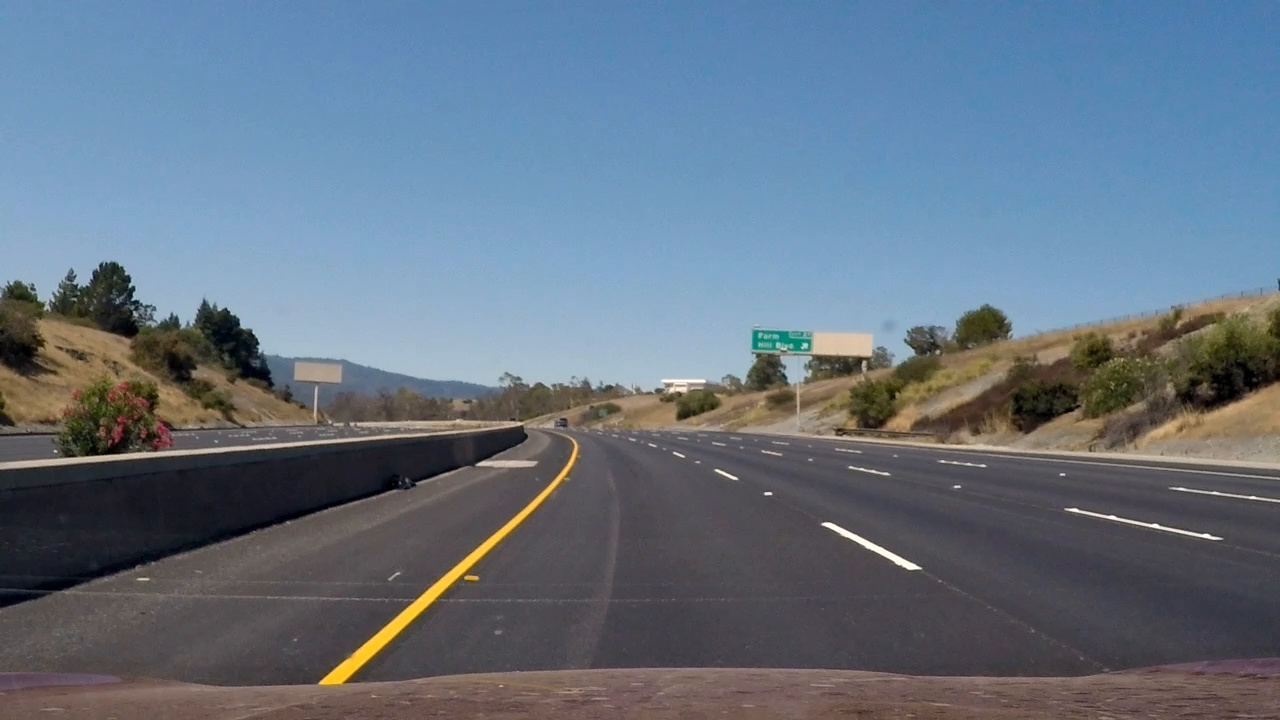

In [16]:
arr2img(vehicle_detection.heatmap_decorated)
#vehicle_detection.result

In [17]:
loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)

rimages=[]
def do_project_video(file_name, output_name):
    height, width = (720,1280)
    
    count=0
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    detection = VehicleDetection(search_params, height, width, loop)
    
    def process_image(image):
        nonlocal count
        
        # process the lane image
        detection.image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        result = cv2.cvtColor(detection.result, cv2.COLOR_BGR2RGB)

        result = cv2.putText(result,'%4d' % count,(5,700), font, 1,(255,255,255),2,cv2.LINE_AA)
        count +=1
        
        rimages.append(result)
        return result
    
    clip1 = VideoFileClip(file_name)    
    lane_clip = clip1.fl_image(process_image) 
    %time lane_clip.write_videofile(output_name, audio=False)
    del clip1.reader
    del clip1
    return lane_clip


#detection_clip = do_project_video("test_video.mp4","test_video_vehicle_detection.mp4")
detection_clip = do_project_video("project_video.mp4","project_video_VehDet.mp4")

[MoviePy] >>>> Building video project_video_VehDet.mp4
[MoviePy] Writing video project_video_VehDet.mp4


100%|█████████████████████████████████████▉| 1260/1261 [24:16<00:01,  1.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_VehDet.mp4 

Wall time: 24min 17s


In [18]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format("project_video_VehDet.mp4"))

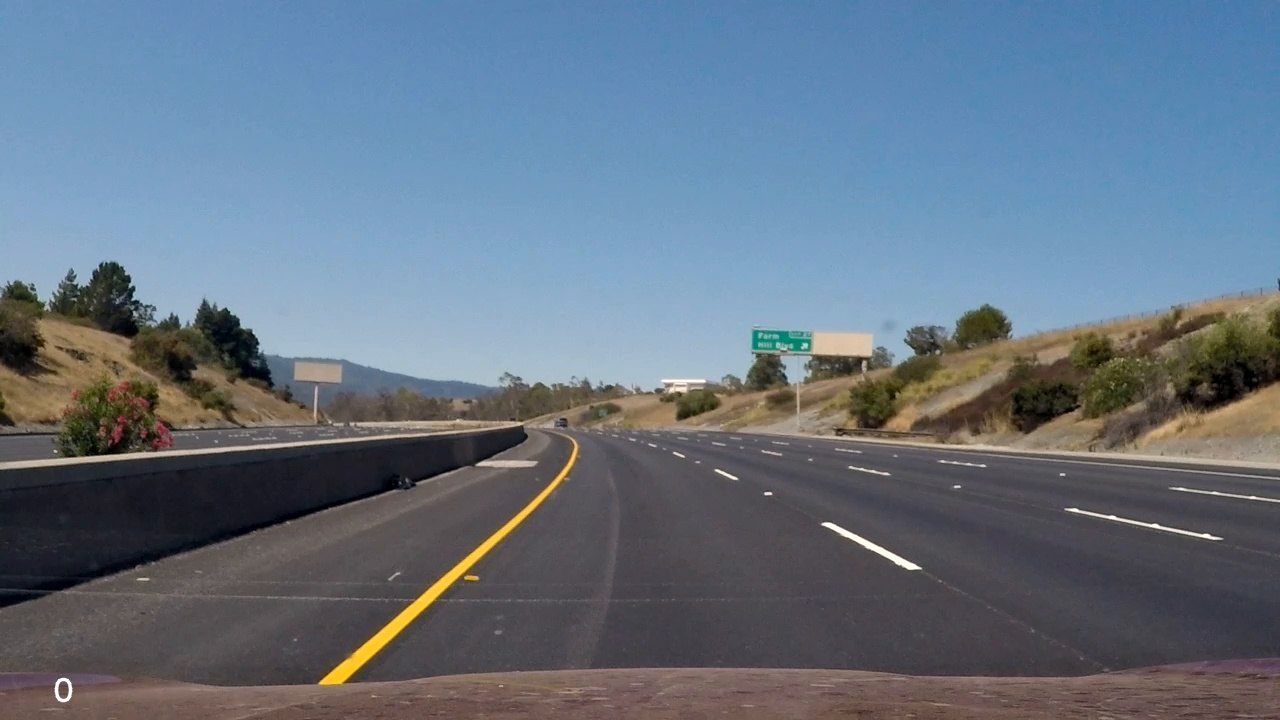

In [19]:
@interact
def result_images_test(images=fixed(rimages), i:(0,len(rimages)-1)=0):
    return arr2img(rimages[i])